In [68]:
import matplotlib.pyplot as plt
import numpy as np
from ensemble_analysis_lib import * # featurize, fit_dimensionality_reduction, transform
import seaborn as sns
import random

# 0- Load and process the data

### t-SNE parameters:
PerplexityVals: this parameter completely described here https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html. Determining the best cluster is based on Silhouette score, this score is computed iteratively for the different perplexity values and number of clusters. Different number of clusters can be tried during the k-means clustering part. Selecting a range of Perplexity Values is based on the number of data points you have. It should not be exceeded the number of data points. "metric" parameter is explained here https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html but I found out for symmetrical matrices we can change it to 'precomputed'. dir is the folder that the data related to tsne are going to be saved there. 

In [63]:
# Codes of the ensembles we want to analyze. In this notebook, they are the
# same of the prefixes of the corresponding PDB files.
ens_codes = [
  
    "combined_45",
    "PED00160",
    "PED00423",
    "PED00424"
]
# Directory with the PDB files.
pdb_dp = "/home/hamid/PED_Data_analysis/giacomo_codes/PDBs/combined_renumbered/"

# Featurization options.
featurization = "phi_psi"  # choices: "ca_dist", "phi_psi" , "a_angle" , "sidechain_dist"
featurization_params = {"ca_dist": {"seq_sep": 2, "normalize": False},
                        "phi_psi": {},
                        "a_angle": {},
                        "sidechain_dist" : {"seq_sep": 2, "normalize": True}}


# Dimensionality reduction options. 'tsne' or 'pca' or 'dimenfix','MDS' , 'tsne-circular'
reduce_dim_method = "tsne-circular"
reduce_dim_params = {"pca": {"num_dim": None}, 
                     "tsne": {"perplexityVals": range(20,50,20),'metric' : 'euclidean',   'dir' :'/home/hamid/PED_Data_analysis/tsne_phi'}, 
                     "dimenfix": {},
                     "tsne-circular" : {"perplexityVals": range(20,50,20),  'dir' :'/home/hamid/PED_Data_analysis/tsne_phi/'}}

### 1- Making your EnsembleAnalysis object
- pdb_dp is the directory which contains the ensembles  <br>
- ens_codes is the basename's list of the multi model pdb files of each ensemble 

In [64]:
pipeline = EnsembleAnalysis(pdb_dp=pdb_dp,
                            ens_codes=ens_codes)

# Loading /home/hamid/PED_Data_analysis/giacomo_codes/PDBs/combined_renumbered/combined_45.dcd.
- Found 1000 conformations.
# Loading /home/hamid/PED_Data_analysis/giacomo_codes/PDBs/combined_renumbered/PED00160.dcd.
- Found 500 conformations.
# Loading /home/hamid/PED_Data_analysis/giacomo_codes/PDBs/combined_renumbered/PED00423.dcd.
- Found 1000 conformations.
# Loading /home/hamid/PED_Data_analysis/giacomo_codes/PDBs/combined_renumbered/PED00424.dcd.
- Found 1000 conformations.


### 2- Extract your desired feature from the ensembles' trajcetories

- featurization is the selected feature (phi-psi or ca_dist)
- featurization_params is the parameters related to each selected feature 

In [65]:
pipeline.featurize(featurization=featurization,
                   featurization_params=featurization_params[featurization])


# Featurizing the combined_45 ensemble.
- Featurized ensemble shape: (1000, 182)
# Featurizing the PED00160 ensemble.
- Featurized ensemble shape: (500, 182)
# Featurizing the PED00423 ensemble.
- Featurized ensemble shape: (1000, 182)
# Featurizing the PED00424 ensemble.
- Featurized ensemble shape: (1000, 182)
Concatenated featurized ensemble shape: (3500, 182)


## 3- Fit dimensionality reduction
- Apply the selected dimensionality reduction method on the selected feature 

In [55]:
pipeline.fit_dimensionality_reduction(
    reduce_dim_method=reduce_dim_method, reduce_dim_params= reduce_dim_params[reduce_dim_method])

tsne for phi_psi is running...
tsne file for the perplexity value of 20 is saved in /home/hamid/PED_Data_analysis/tsne_phi/ 
tsne file for the perplexity value of 40 is saved in /home/hamid/PED_Data_analysis/tsne_phi/ 
tsne is done! All files saved in /home/hamid/PED_Data_analysis/tsne_phi/


#  4- Dimensionality reduction Analysis & Visulization

## 4-1 : **t-SNE/ t-SNE circular**
 ## Run the next cell only if you select **tsne** as your selected dimensionality reduction method!

- Trying different number of clusters and different perplexity values to find the optimim silhouette score
- All the results are going to be saved in a directory determined in the step zero

In [66]:
range_n_clusters = range(2,10,1) # different range of n_cluster is added here
# Specific to T-SNE
if reduce_dim_method == "tsne" or reduce_dim_method == "tsne-circular":
    from sklearn import metrics
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score
    range_n_clusters = range_n_clusters 
    perplexityVals = reduce_dim_params[reduce_dim_method]['perplexityVals']
    for perp in perplexityVals:
        tsne = np.loadtxt(reduce_dim_params['tsne']['dir'] + '/tsnep'+str(perp))
        for n_clusters in range_n_clusters:

            kmeans = KMeans(n_clusters=n_clusters, n_init= 'auto').fit(tsne)
            np.savetxt(reduce_dim_params['tsne']['dir'] + '/kmeans_'+str(n_clusters)+'clusters_centers_tsnep'+str(perp), kmeans.cluster_centers_, fmt='%1.3f')
            np.savetxt(reduce_dim_params['tsne']['dir'] + '/kmeans_'+str(n_clusters)+'clusters_tsnep'+str(perp)+'.dat', kmeans.labels_, fmt='%1.1d')
            
            silhouette_ld = silhouette_score(tsne, kmeans.labels_)
            silhouette_hd = metrics.silhouette_score(pipeline.concat_features, kmeans.labels_)
   
            with open(reduce_dim_params['tsne']['dir']  + '/silhouette.txt', 'a') as f:
                f.write("\n")
                print(perp, n_clusters, silhouette_ld, silhouette_hd, silhouette_ld*silhouette_hd, file =f)
else:
    print("Check your reduced dimensionality method")

### 4-3 Visulization of conformations in the 2D space using t-SNE

40.0 2.0


/tmp/ipykernel_777799/1133438420.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet', bestK)


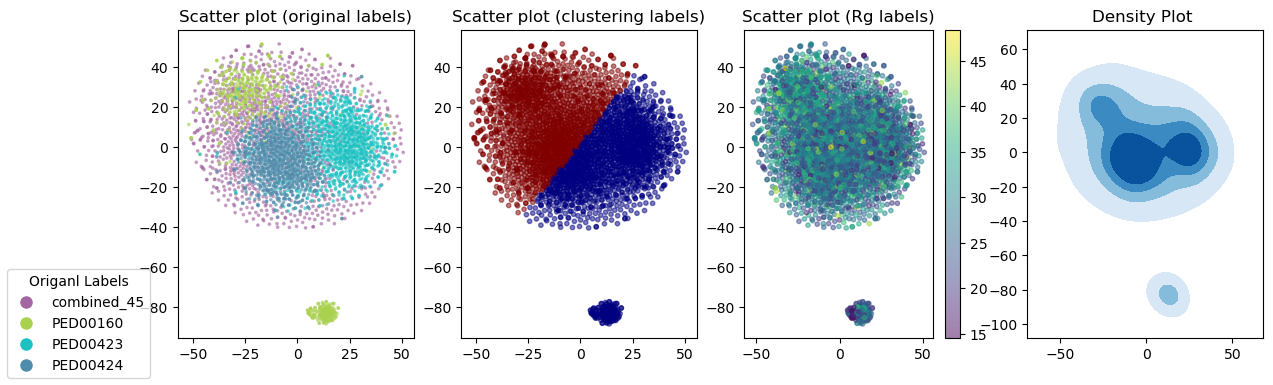

In [69]:
if reduce_dim_method == "tsne" or reduce_dim_method == "tsne-circular":
    
    fig , (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(14 ,4)) 
    import matplotlib.cm as cm
    s = np.loadtxt(reduce_dim_params[reduce_dim_method]['dir']  +'/silhouette.txt')
    [bestP,bestK] = s[np.argmax(s[:,4]), 0], s[np.argmax(s[:,4]), 1]
    besttsne = np.loadtxt(reduce_dim_params[reduce_dim_method]['dir']  + '/tsnep'+str(int(bestP)))
    bestclust = np.loadtxt(reduce_dim_params[reduce_dim_method]['dir']  +'/kmeans_'+str(int(bestK))+'clusters_tsnep'+str(int(bestP))+'.dat')
    print(bestP, bestK)
   

    # scatter original  labels
    label_colors = {label: "#{:06x}".format(random.randint(0, 0xFFFFFF)) for label in ens_codes}
    point_colors = list(map(lambda label: label_colors[label], pipeline.all_labels))
    scatter_labeled = ax1.scatter(besttsne[:, 0], besttsne[:, 1], c=point_colors, s=3, alpha = 0.5)
    
    # scatter Rg labels 
    # Rg in Angstrom
    rg_labeled = ax3.scatter(besttsne[:, 0], besttsne[:, 1], c= [rg for rg in pipeline.rg_calculator()], s=10, alpha=0.5) 
    cbar = plt.colorbar(rg_labeled, ax=ax3)
    
    # scatter cluster labels
    cmap = cm.get_cmap('jet', bestK)
    scatter_cluster = ax2.scatter(besttsne[:,0], besttsne[:,1], c= bestclust.astype(float), s=10,cmap=cmap ,alpha=0.5)
    
    # manage legend
    legend_labels = list(label_colors.keys())
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=label_colors[label], markersize=10) for label in legend_labels]
    fig.legend(legend_handles, legend_labels, title='Origanl Labels', loc = 'lower left')

    # KDE plot
    sns.kdeplot(x=besttsne[:, 0], y=besttsne[:, 1], ax=ax4, fill=True, cmap='Blues', levels=5)

    # ax1.scatter(grid_positions[0, densest_indices], grid_positions[1, densest_indices], c='red', marker='x', s=50, label='Densest Points')
    ax1.set_title('Scatter plot (original labels)')
    ax2.set_title('Scatter plot (clustering labels)')
    ax3.set_title('Scatter plot (Rg labels)')
    ax4.set_title('Density Plot ')
    
    plt.savefig(reduce_dim_params[reduce_dim_method]['dir']  +'/tsnep'+str(int(bestP))+'_kmeans'+str(int(bestK))+'.png', dpi=800)
else:
    print("Check your reduced dimensionality method")
    